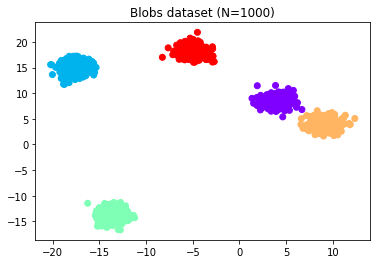

Best number of clusters: 5
Test set prediction ACC: 1.0
AMI (true labels vs predicted labels) = 1.0
Validation set normalized stability (misclassification):(0.0, (0.0, 0.0))
Test set ACC = 1.0 (true labels vs predicted labels)


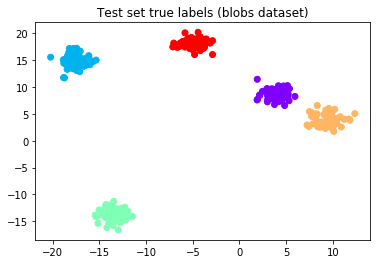

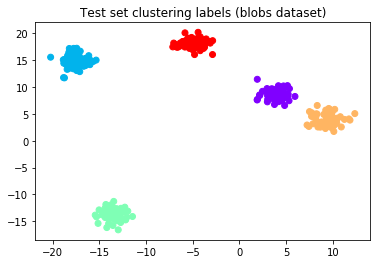

In [1]:
from sklearn.datasets import make_blobs, load_digits
from sklearn.model_selection import train_test_split
from reval.best_nclust_cv import FindBestClustCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.metrics import zero_one_loss, adjusted_mutual_info_score
from reval.visualization import plot_metrics
import matplotlib.pyplot as plt
from reval.utils import kuhn_munkres_algorithm
from umap import UMAP
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np
from datasets.manuscript_builddatasets import build_ucidatasets
import warnings
import logging

logging.basicConfig(filename='manuscript_examples.log',
                    filemode='a',
                    format='%(asctime)s, %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

"""
Three example functions that can be run from shell (change main at the bottom). 

Example 1: blobs dataset;
Example 2: real-world dataset (handwritten digits)
Example 3: ensamble learning with 18 datasets from UCI Machine Learning Repository.
           Algorithm performances are saved to manuscript_example.log file.
"""


# EXAMPLE 1: Isotropic Gaussian blobs
data = make_blobs(1000, 2, 5, center_box=(-20, 20),
                  random_state=42)
plt.figure(figsize=(6, 4))
plt.scatter(data[0][:, 0],
            data[0][:, 1],
            c=data[1], cmap='rainbow_r')
plt.title("Blobs dataset (N=1000)")
plt.show()

X_tr, X_ts, y_tr, y_ts = train_test_split(data[0],
                                          data[1],
                                          test_size=0.30,
                                          random_state=42,
                                          stratify=data[1])

classifier = KNeighborsClassifier(n_neighbors=5)
clustering = KMeans()

findbestclust = FindBestClustCV(nfold=10,
                                nclust_range=[2, 7],
                                s=classifier,
                                c=clustering,
                                nrand=100)
metrics, nbest, _ = findbestclust.best_nclust(X_tr, iter_cv=10, strat_vect=y_tr)
out = findbestclust.evaluate(X_tr, X_ts, nbest)

perm_lab = kuhn_munkres_algorithm(y_ts, out.test_cllab)

print(f"Best number of clusters: {nbest}")
print(f"Test set prediction ACC: "
      f"{1 - zero_one_loss(y_ts, perm_lab)}")
print(f'AMI (true labels vs predicted labels) = '
      f'{adjusted_mutual_info_score(y_ts, out.test_cllab)}')
print(f"Validation set normalized stability (misclassification):"
      f"{metrics['val'][nbest]}")
print(f'Test set ACC = {out.test_acc} '
      f'(true labels vs predicted labels)')

plt.figure(figsize=(6, 4))
plt.scatter(X_ts[:, 0], X_ts[:, 1],
            c=y_ts, cmap='rainbow_r')
plt.title("Test set true labels (blobs dataset)")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(X_ts[:, 0], X_ts[:, 1],
            c=perm_lab, cmap='rainbow_r')
plt.title("Test set clustering labels (blobs dataset)")
plt.show()

In [ ]:
# EXAMPLE 2: Handwritten digits dataset example
digits_dataset = load_digits()

digits_data = digits_dataset['data']
digits_target = digits_dataset['target']

X_tr, X_ts, y_tr, y_ts = train_test_split(digits_data,
                                          digits_target,
                                          test_size=0.40,
                                          random_state=42,
                                          stratify=digits_target)

transform = UMAP(n_components=2,
                 random_state=42,
                 n_neighbors=30,
                 min_dist=0.0)
X_tr = transform.fit_transform(X_tr)
X_ts = transform.transform(X_ts)

s = KNeighborsClassifier(n_neighbors=30)
c = KMeans()

reval = FindBestClustCV(s=s,
                        c=c,
                        nfold=5,
                        nclust_range=[2, 15],
                        nrand=100)

metrics, nclustbest, _ = reval.best_nclust(X_tr, iter_cv=10, strat_vect=y_tr)

plot_metrics(metrics, title='Reval performance digits dataset')

out = reval.evaluate(X_tr, X_ts, nclust=nclustbest)
perm_lab = kuhn_munkres_algorithm(y_ts, out.test_cllab)

print(f"Best number of clusters: {nclustbest}")
print(f"Test set prediction ACC: "
      f"{1 - zero_one_loss(y_ts, perm_lab)}")
print(f'AMI (true labels vs predicted labels) = '
      f'{adjusted_mutual_info_score(y_ts, out.test_cllab)}')
print(f"Validation set normalized stability (misclassification):"
      f"{metrics['val'][nclustbest]}")
print(f'Test set ACC = {out.test_acc} '
      f'(true labels vs predicted labels)')

plt.figure(figsize=(6, 4))
plt.scatter(X_ts[:, 0],
            X_ts[:, 1],
            c=y_ts, cmap='rainbow_r')
plt.title("Test set true labels (digits dataset)")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(X_ts[:, 0],
            X_ts[:, 1],
            c=perm_lab, cmap='rainbow_r')
plt.title("Test set clustering labels (digits dataset)")
plt.show()

In [ ]:
# Example 3: ensemble learning
# Classifiers
knn = KNeighborsClassifier(n_neighbors=1,
                           metric='euclidean')
rf = RandomForestClassifier(n_estimators=100,
                            random_state=42)
svm = SVC(C=1,
          random_state=42)
logreg = LogisticRegression(solver='liblinear',
                            random_state=42)

classifiers = [knn, logreg, svm, rf]

# Clustering
hc = AgglomerativeClustering()
km = KMeans(random_state=42)
sc = SpectralClustering(random_state=42)

clustering = [hc, km, sc]

# scaler = StandardScaler()
transform = UMAP(n_neighbors=30, min_dist=0.0, random_state=42)

# Import benchmark datasets
uci_data = build_ucidatasets()
# Run ensemble learning algorithm
for data, name in zip(uci_data, uci_data._fields):
    nclass = len(np.unique(data['target']))
    logging.info(f"Processing dataset {name}")
    logging.info(f"Number of classes: {nclass}\n")
    X_tr, X_ts, y_tr, y_ts = train_test_split(data['data'],
                                              data['target'],
                                              test_size=0.40,
                                              random_state=42,
                                              stratify=data['target'])
    X_tr = transform.fit_transform(X_tr)
    X_ts = transform.transform(X_ts)
    for s in classifiers:
        if type(s) == type(svm):
            svm.gamma = 1 / data['data'].shape[0]
        for c in clustering:
            logging.info(f"Clustering algorithm: {c} -- Classification algorithm {s}")
            reval = FindBestClustCV(s=s,
                                    c=c,
                                    nfold=5,
                                    nclust_range=[2, nclass + 3],
                                    nrand=100)
            metrics, nclustbest, _ = reval.best_nclust(X_tr, strat_vect=y_tr)

            out = reval.evaluate(X_tr, X_ts, nclust=nclustbest)
            perm_lab = kuhn_munkres_algorithm(y_ts, out.test_cllab)

            logging.info(f"Best number of clusters: {nclustbest}")
            logging.info(f"Test set prediction ACC: "
                         f"{1 - zero_one_loss(y_ts, perm_lab)}")
            logging.info(f'AMI (true labels vs predicted labels) = '
                         f'{adjusted_mutual_info_score(y_ts, out.test_cllab)}')
            logging.info(f"Validation set normalized stability (misclassification):"
                         f"{metrics['val'][nclustbest]}")
            logging.info(f'Test set ACC = {out.test_acc} '
                         f'(true labels vs predicted labels)\n')
    logging.info('*' * 100)
    logging.info('\n\n')